In [1]:
# ==============================================================================
#
# (encoder: ResNet) + (latent_variable: N(0,1)) + (decoder: reversed ResNet)
#
# ==============================================================================

In [2]:
import torch
import torch.nn as nn
from models import *

latent_size = 500

encoder = resnet34()
# encoder.eval()
decoder = decoder31()
# decoder.eval()
net = VAE(encoder, decoder, latent_size)
# vae.eval()

checkpoint = torch.load('./checkpoint/vae_weights.pth.tar', map_location='cpu')
net.load_state_dict(checkpoint['state_dict'])
    

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

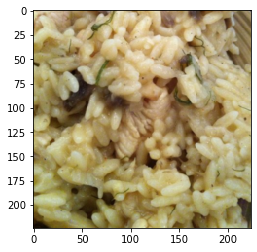

In [3]:
import matplotlib.pyplot as plt
from dataloader import *

# Data setup
loader = KeyDataLoader(224, 32)
train_loader, valid_loader, test_loader = loader.run(8, 1, data_dir='../food')

x, targets = next(iter(train_loader))
plt.imshow(x[1].permute(1, 2, 0))

In [4]:
with torch.no_grad():
    feats, _ = net.encode(x)
    
feats.shape

torch.Size([8, 500])

In [5]:
import random

targets_fast = targets.clone()
randidx = torch.randperm(targets.size(0))
for n in range(int(targets.size(0)*0.5)):
    num_neighbor = 2
    idx = randidx[n]
    feat = feats[idx]
    feat.view(1,feat.size(0))
    feat.data = feat.data.expand(targets.size(0),feat.size(0))
    dist = torch.sum((feat-feats)**2,dim=1)
    _, neighbor = torch.topk(dist.data,num_neighbor+1,largest=False)
    targets_fast[idx] = targets[neighbor[random.randint(1,num_neighbor)]]

In [6]:
targets_fast

tensor([ 7,  7,  1, 67,  7,  4,  4, 35])

In [7]:
targets

tensor([60,  7, 36, 67,  2,  1,  4, 35])